<a href="https://colab.research.google.com/github/alexisjkim/conformal_prediction_limitations/blob/main/Conformal_Prediction_Limitations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [249]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset, TensorDataset
import torchvision

import pandas as pd
import cv2


In [250]:
# loading data and splitting into train, calibration, test sets

batch_size = 128

# this dataset has the training data from MNIST; will be split into training and calibration sets
mnist_train_set = torchvision.datasets.MNIST(root='./datasets/',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)



# this dataset has the test data from MNIST
mnist_test_dataset = torchvision.datasets.MNIST(root='./datasets',
                                          train=False,
                                          transform=torchvision.transforms.ToTensor())


train_percentage = 0.8 # this percentage of the training data set stays in the train set; the rest becomes part of the calibration set

train_size = int(train_percentage *len(mnist_train_set))
calibration_size = len(mnist_train_set) - train_size

mnist_train_set, mnist_cal_set = random_split(mnist_train_set, [train_size, calibration_size])

# Data loader
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

# We use drop_last=True to avoid the case where the data / batch_size != int

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print("SIZES OF DATASETS: ")
print("training set: ", len(mnist_train_loader.dataset))
print("calibration set: ", len(mnist_cal_loader.dataset))
print("testing set: ", len(mnist_test_loader.dataset))

SIZES OF DATASETS: 
training set:  48000
calibration set:  12000
testing set:  10000


In [251]:
# class for our neural network

class TwoLayerNetPiped(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        Parameters:
            D_in - dimensions of inputs
            H - number of hidden units per layer
            D_out - dimensions of outputs
        """
        # initialzing the parent object (important!)
        super(TwoLayerNetPiped, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),
            torch.nn.ReLU(),
            torch.nn.Linear(H, D_out))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        Parameters:
            x - tensor of inputs (shape: [BATCH_SIZE, D_in])
        """
        return self.pipe(x)

In [252]:
# Setting up the model

# hyper-parameters:
num_epochs = 3
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Loss and optimizer
criterion = nn.CrossEntropyLoss()


In [253]:
# Train the model, given a training set in DataLoader form

def train_model(loader, model, optimizer):

    model.train()  # training mode
    total_step = len(loader)
    start_time = time.time()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            # each i is a batch of 128 samples
            images = images.to(device).view(batch_size, -1)  # represent images as column vectors
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize - ALWAYS IN THIS ORDER!
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs'
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), time.time() - start_time))

In [254]:
# create model, send it to device
og_model = TwoLayerNetPiped(D_in=28*28, H=256, D_out=10).to(device)

optimizer = torch.optim.Adam(og_model.parameters(), lr=learning_rate)

In [255]:
train_model(mnist_train_loader, og_model, optimizer)

Epoch [1/3], Step [100/375], Loss: 0.2518, Time: 0.5676 secs
Epoch [1/3], Step [200/375], Loss: 0.3710, Time: 1.0654 secs
Epoch [1/3], Step [300/375], Loss: 0.1691, Time: 1.5323 secs
Epoch [2/3], Step [100/375], Loss: 0.3747, Time: 2.4533 secs
Epoch [2/3], Step [200/375], Loss: 0.1342, Time: 2.9885 secs
Epoch [2/3], Step [300/375], Loss: 0.1769, Time: 3.5046 secs
Epoch [3/3], Step [100/375], Loss: 0.1006, Time: 4.3243 secs
Epoch [3/3], Step [200/375], Loss: 0.1107, Time: 4.7994 secs
Epoch [3/3], Step [300/375], Loss: 0.1915, Time: 5.2571 secs


In [256]:
# Prints out the accuracy of a model, given a model and the test data

def test_model(model, loader):

  model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance), or use:
  with torch.no_grad(): # "don't keep track of the gradients" ,can also use .detach()
      correct = 0
      total = 0
      for images, labels in loader:
          images = images.to(device).view(images.size(0), -1) #image.size(0) returns batch size
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      #print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


test_model(og_model, mnist_test_loader)

In [257]:
# Takes in a model and a calibration/testing set, and returns: 1) a list of the softmaxes for each class, and 2) the indexes that have the highest softmaxes (aka predicted values)

def get_probabilities_and_predictions(model, loader):
    probs_list = []
    preds_list = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device).view(images.size(0), -1) # prepares image for input into model by flattening into a 1d vector
            outputs = model(images) # get output of the model when given the image as input
            probabilities = torch.nn.functional.softmax(outputs, dim = 1) #1 corresponds to columns
            #the prediction outputs the index of what it thinks the class is
            #the omitted term is the value
            _, predictions = torch.max(outputs.data, 1) # prediction = the index of the highest softmax value (aka the model's prediction). omitted term is the value 
            # Append to lists
            preds_list.extend(predictions.cpu().numpy())
            probs_list.extend(probabilities.cpu().numpy())

    return probs_list, preds_list

Conformal prediction starts here

In [258]:
# Given alpha value and a calibration set loader, returns the quantile (aka threshold for which all testing softmax scores below it should be ) 

def get_quantile(alpha, loader):

  cal_probs = []
  cal_preds = []
  cal_probs, cal_preds = get_probabilities_and_predictions(og_model, loader)

  cal_scores = []
  for prob, true_label in zip(cal_probs, cal_preds): #prob is the probability and true_label is index of pred
    true_class_prob = prob[true_label] #the corresponding lists with their prob function getting the most predicted class
    cal_scores.append(1 - true_class_prob) #s_i score

  cal_scores = np.array(cal_scores)
  sorted_scores = np.sort(cal_scores) #probabilities

  n = 0
  for _, labels in loader:
    n += labels.size(0)
    
  q_level = math.ceil((1 - alpha) * (n + 1)) / n

  
# print(f"Adjusted quantile level: {q_level}")
  return np.quantile(sorted_scores, min(1, q_level))




In [259]:
alpha = 0.05
threshold = get_quantile(alpha, mnist_cal_loader) #for the calibration set
print(threshold)

0.28211708219661824


In [260]:
# Returns prediction set

def conformal_prediction(probabilities, threshold):
    predictions = []
    for prob in probabilities:
        sorted_indices = np.argsort(prob)[::-1]
     #   total = 0.0
     #   prediction = []
     #   for i in sorted_indices:
        #    total += prob[i]
        #    prediction.append(i)
        #    if total > 1 - threshold: #we do 1 - threshold because we want to observe the right side as we are adding in ascending order
        #        break
        # predictions.append(prediction)

        prediction = []

        for i in range(len(prob)):
            if prob[i] >= 1 - threshold:
                prediction.append(i)

        predictions.append(prediction)
    return predictions





In [261]:
#evaluation
def evaluate_and_print(observed_labels, conformal_prediction, predicted, start_row, end_row, should_i_print=True):
  formatted_output = pd.DataFrame({
    'observed labels': observed_labels,
    'conformal prediction set': conformal_prediction,
    'prediction': predicted
  })


  #evaluation metric
  hits = 0
  total = len(observed_labels)
  for i in range(len(observed_labels)):
    conf_pred_row = conformal_prediction[i]
    observed = observed_labels[i]

    if observed in conf_pred_row:
      hits += 1

  score = hits/total *100

  if (should_i_print == True):
    print("the prediction was in the set ", score, " percent of the time")
    print(formatted_output[start_row:end_row])

  return score


In [262]:
#getting observed label functions
def get_observed_labels(loader):
    observed_labels = []
    with torch.no_grad():
        for images, labels in loader:
            observed_labels.extend(labels.cpu().numpy())
    return observed_labels

In [263]:
#evaluating our testing data set

test_observed_labels = get_observed_labels(mnist_test_loader)

test_probs = []
test_preds = []
test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader)


conformal_predictions = conformal_prediction(test_probs, threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
train_test_same_score = evaluate_and_print(test_observed_labels, conformal_predictions, test_preds, 300, 450)



The conformal prediction accuracy based on training data and testing data from the same distribution is:
the prediction was in the set  93.78999999999999  percent of the time
     observed labels conformal prediction set  prediction
300                4                       []           4
301                7                      [7]           7
302                1                      [1]           1
303                2                      [2]           2
304                4                      [4]           4
..               ...                      ...         ...
445                6                      [0]           0
446                6                      [6]           6
447                4                      [4]           4
448                9                      [8]           8
449                3                      [3]           3

[150 rows x 3 columns]


In [264]:
# PART 2: reducing the size of the calibration set

alpha = 0.05

cal_set_size = [] # x axis
accuracy_scores = [] # y axis
average_sizes = []

test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader) # Get the softmaxes and predictions from the test data set
labels = get_observed_labels(mnist_test_loader) # Get ground truth labels, and the softmaxes and predictions

for i in range(1, 700, 10):

    # Shrinks the  calibration set to be i elements, and makes it into a new loader called reduced_loader
    reduced_dataset = Subset(mnist_cal_loader.dataset, list(range(i)))
    reduced_loader = DataLoader(reduced_dataset, batch_size=batch_size, shuffle=False)

    print("size: ", len(reduced_loader.dataset))

    # Get threshold value based on the reduced_loader
    reduced_threshold = get_quantile(alpha, reduced_loader)

    # Get the conformal prediction sets for the reduced_loader based on the reduced_threshold
    reduced_conformal_predictions = conformal_prediction(test_probs, reduced_threshold)

    # i (size of calibration set) is the x axis for our graph
    cal_set_size.append(i)

    # reduced_score = the accuracy score of our reduced dataset; it is the y axis of our graph
    reduced_score = evaluate_and_print(labels, reduced_conformal_predictions, test_preds, 0, len(labels),True)


    sizes = [len(sublist) for sublist in reduced_conformal_predictions]
    total_size = sum(sizes)
    num_sublists = len(reduced_conformal_predictions)
    average_size = total_size / num_sublists
    average_sizes.append(average_size)

    accuracy_scores.append(reduced_score)
#   print("score: ", reduced_score)
    
    mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    

size:  1
the prediction was in the set  25.19  percent of the time
      observed labels conformal prediction set  prediction
0                   7                       []           7
1                   2                      [2]           2
2                   1                       []           1
3                   0                      [0]           0
4                   4                       []           4
...               ...                      ...         ...
9995                2                      [2]           2
9996                3                      [3]           3
9997                4                       []           4
9998                5                       []           5
9999                6                      [6]           6

[10000 rows x 3 columns]
size:  11
the prediction was in the set  88.52  percent of the time
      observed labels conformal prediction set  prediction
0                   7                      [7]           7
1            

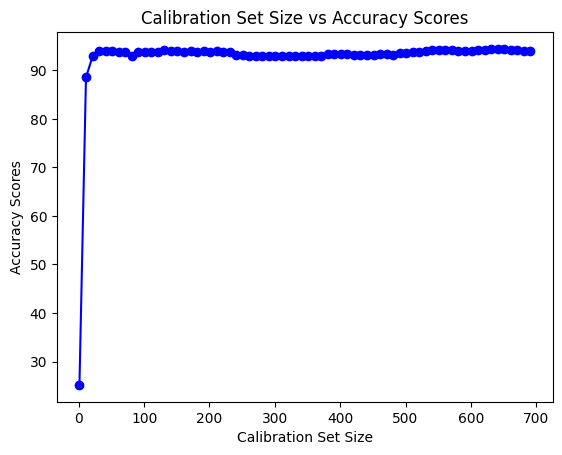

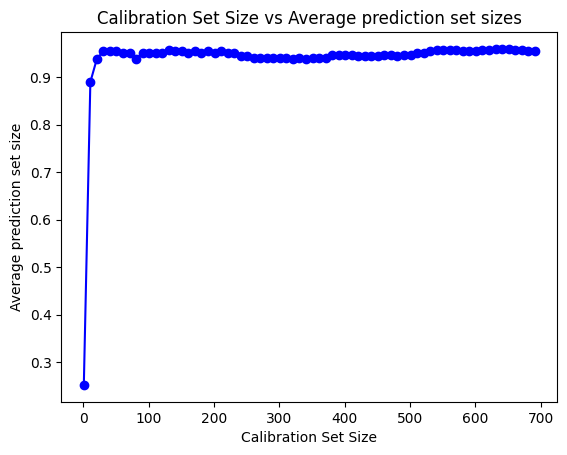

In [265]:
plt.plot(cal_set_size, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')  # Plot the data
plt.title('Calibration Set Size vs Accuracy Scores')
plt.xlabel('Calibration Set Size')
plt.ylabel('Accuracy Scores')
plt.show()


plt.plot(cal_set_size, average_sizes, marker='o', linestyle='-', color='b', label='Accuracy')  # Plot the data
plt.title('Calibration Set Size vs Average prediction set sizes')
plt.xlabel('Calibration Set Size')
plt.ylabel('Average prediction set size')
plt.show()

In [ ]:
alpha = 0.05
threshold = get_quantile(alpha, mnist_cal_loader) #for the calibration set
print(threshold)

Repeating the experiment with test data that doesn't match the calibration set.

Functions for Blurring

In [ ]:
def blur_images(image):
  return torch.tensor(cv2.blur(image.numpy(), (30, 30)))

In [ ]:
#get blurred data
#blur the images
def get_blurred_data(loader):
    blurred_images = []
    blurred_labels = []

    # adding blur to every image in the training set
    with torch.no_grad():
        for images, labels in loader:
            for i in range(len(images)):
                blurred_image = blur_images(images[i])
                blurred_images.append(blurred_image)
                blurred_labels.append(labels[i])

    blurred_images = torch.stack(blurred_images)
    blurred_labels = torch.tensor(blurred_labels)

    return blurred_images, blurred_labels

In [ ]:
def create_blur_loader(blurred_images, blurred_labels):
    # Create a TensorDataset and DataLoader for the blurred images
    blurred_dataset = TensorDataset(blurred_images, blurred_labels)
    blurred_loader = DataLoader(blurred_dataset, batch_size=128, shuffle=False)
    return blurred_loader

In [ ]:
#testing our model on blurred images

blur_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blur_loader)

blurred_images, blurred_labels = get_blurred_data(blur_loader)
blurred_loader = create_blur_loader(blurred_images, blurred_labels)

blur_probs = []
blur_preds = []
test_model(og_model, blurred_loader)
blur_probs, blur_preds = get_probabilities_and_predictions(og_model, blurred_loader)
'''''
blur_probs = []
blur_pred = []

# Flatten images for model input
blurred_images = blurred_images.view(len(blurred_images), -1).to(device)

#find probabilities and predictions
with torch.no_grad():
  outputs = model(blurred_images)
  probabilities = torch.nn.functional.softmax(outputs, dim = 1)
  _, blur_pred = torch.max(outputs.data, 1)


blur_preds = blur_pred.cpu().numpy()
blur_probs = probabilities.cpu().numpy()'''


conformal_predictions = conformal_prediction(blur_probs, threshold)
print("This is the conformal prediction accuracy based on training data and testing data from different distributions. \nThe training data contains normal images while the testing data were all blurred:")
train_blur_test_score = evaluate_and_print(observed_labels, conformal_predictions, blur_preds, 10, 200)



This is the conformal prediction accuracy based on training data and testing data from different distributions. 
The training data contains normal images while the testing data were all blurred:
the prediction was in the set  12.620000000000001  percent of the time
     observed labels conformal prediction set  prediction
10                 0                       []           5
11                 6                       []           5
12                 9                      [3]           3
13                 0                       []           5
14                 1                      [1]           1
..               ...                      ...         ...
195                3                       []           3
196                1                       []           1
197                6                      [3]           3
198                4                       []           3
199                2                      [3]           3

[190 rows x 3 columns]


Training on blurred Images

In [ ]:
# Train the model -- additional training on blurred images without calibration


blurred_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                          batch_size=batch_size,
                                          shuffle=False)


observed_labels = get_observed_labels(blurred_train_loader)

blurred_images, blurred_labels = get_blurred_data(blurred_train_loader)
blurred_train_loader = create_blur_loader(blurred_images, blurred_labels)
blur_train_probs = []
blur_train_preds = []
blur_probs, blur_preds = get_probabilities_and_predictions(og_model, blurred_train_loader)


train_model(blurred_train_loader, og_model, optimizer)


Epoch [1/3], Step [100/375], Loss: 0.8973, Time: 0.1332 secs
Epoch [1/3], Step [200/375], Loss: 0.6737, Time: 0.2660 secs
Epoch [1/3], Step [300/375], Loss: 0.5386, Time: 0.4430 secs
Epoch [2/3], Step [100/375], Loss: 0.4344, Time: 0.7649 secs
Epoch [2/3], Step [200/375], Loss: 0.3401, Time: 0.9032 secs
Epoch [2/3], Step [300/375], Loss: 0.3234, Time: 1.0479 secs
Epoch [3/3], Step [100/375], Loss: 0.3295, Time: 1.2794 secs
Epoch [3/3], Step [200/375], Loss: 0.2376, Time: 1.4727 secs
Epoch [3/3], Step [300/375], Loss: 0.2576, Time: 1.6138 secs


In [ ]:
#now use original calibration (the conformal predicition with the blurry images)

#creating blurry images again

blur_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = get_observed_labels(blur_test_loader)

blurred_images, blurred_labels = get_blurred_data(blur_test_loader)
blurred_test_loader = create_blur_loader(blurred_images, blurred_labels)


blur_test_preds = []
blur_test_probs = []

blur_test_probs, blur_test_preds = get_probabilities_and_predictions(og_model, blurred_test_loader)


conformal_predictions = conformal_prediction(blur_test_probs, threshold)
print("After putting additional training with blurred images with no recalibration:")
retrain_blur_norecal_score = evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


After putting additional training with blurred images with no recalibration:
the prediction was in the set  83.19  percent of the time
     observed labels conformal prediction set  prediction
100                6                      [6]           6
101                0                      [0]           0
102                5                      [5]           5
103                4                      [4]           4
104                9                      [9]           9
105                9                      [9]           9
106                2                      [2]           2
107                1                      [1]           1
108                9                      [9]           9
109                4                      [4]           4
110                8                       []           8
111                7                       []           7
112                3                      [3]           3
113                9                      [9]        

We want to compare 3 things
1) The original data
2) No retraing, no recalibration, feed test data with all blurred images
3) adding training but use original calibration, and feed blurred images

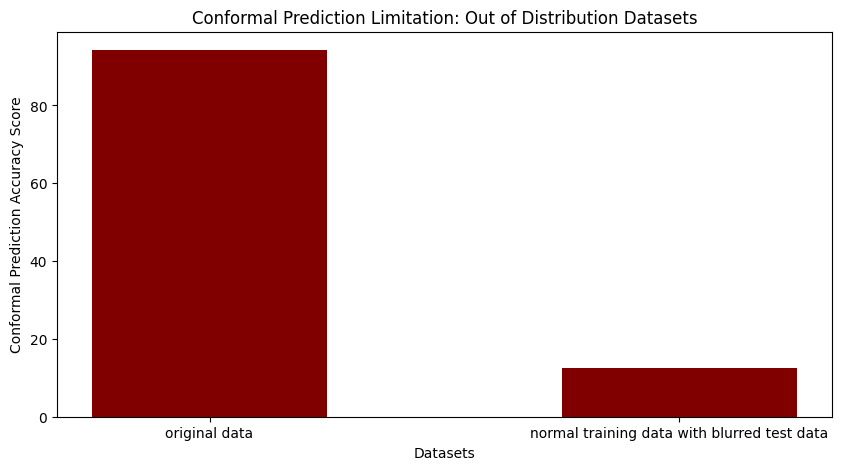

In [ ]:
import matplotlib.pyplot as plt

data = {'original data': train_test_same_score, 
        'normal training data with blurred test data': train_blur_test_score}

training_or_testing_set = list(data.keys())
conformal_prediction_accuracy_score = list(data.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(training_or_testing_set, conformal_prediction_accuracy_score, color = 'maroon', width = 0.5)

plt.xlabel("Datasets")
plt.ylabel("Conformal Prediction Accuracy Score")
plt.title("Conformal Prediction Limitation: Out of Distribution Datasets")
plt.show()


In [ ]:
#Now lets compare. lets calibrate the new blurred images
#Calibration of the blurred images

#blur everyother image in the calibration data


mnist_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)


#blurs every other images
new_cal_images = []
new_cal_labels = []
with torch.no_grad():
    for images, labels in mnist_cal_loader:
        for i in range(len(images)):
          if i % 2 == 0:
            blurred_image = blur_images(images[i])
            new_cal_images.append(blurred_image)
            new_cal_labels.append(labels[i])
          else:
            new_cal_images.append(images[i])
            new_cal_labels.append(labels[i])


new_cal_images = torch.stack(new_cal_images)
new_cal_labels = torch.tensor(new_cal_labels)

new_cal_loader = create_blur_loader(new_cal_images, new_cal_labels)

new_cal_observed_labels = get_observed_labels(new_cal_loader)

alpha = 0.05
new_cal_threshold = get_quantile(alpha, new_cal_loader) #for the calibration set
print(new_cal_threshold)

#after calibrating get the accuracy
# we calibratted on 50:50 now we want to test on all blurred images

conformal_predictions = conformal_prediction(blur_test_probs, new_cal_threshold)
print("After putting additional training with blurred images with no recalibration:")
evaluate_and_print(observed_labels, conformal_predictions, blur_test_preds, 100, 150)


0.48249702260739363
After putting additional training with blurred images with no recalibration:
the prediction was in the set  89.22  percent of the time
     observed labels conformal prediction set  prediction
100                6                      [6]           6
101                0                      [0]           0
102                5                      [5]           5
103                4                      [4]           4
104                9                      [9]           9
105                9                      [9]           9
106                2                      [2]           2
107                1                      [1]           1
108                9                      [9]           9
109                4                      [4]           4
110                8                      [8]           8
111                7                      [7]           7
112                3                      [3]           3
113                9             

89.22

In [ ]:
#sanity check -- what happens if you test with all non-bluured images with 50:50 calibration
test_probs = []
test_preds = []
test_probs, test_preds = get_probabilities_and_predictions(og_model, mnist_test_loader)



test_observed_labels = get_observed_labels(mnist_test_loader)
new_cal_normal_conformal_predictions = conformal_prediction(test_probs, new_cal_threshold)
print("The conformal prediction accuracy based on training data and testing data from the same distribution is:")
evaluate_and_print(test_observed_labels, new_cal_normal_conformal_predictions, test_preds, 300, 450)

The conformal prediction accuracy based on training data and testing data from the same distribution is:
the prediction was in the set  24.94  percent of the time
     observed labels conformal prediction set  prediction
300                4                      [7]           7
301                7                      [2]           2
302                1                      [1]           1
303                2                      [2]           2
304                4                      [2]           2
..               ...                      ...         ...
445                6                      [0]           0
446                6                      [7]           7
447                4                      [5]           5
448                9                      [5]           5
449                3                      [2]           2

[150 rows x 3 columns]


24.94

In [ ]:
def blur_some(loader, value):
    blur_count = 0
    non_blur_count = 0
    blur_some_images = []
    blur_some_labels = []
    with torch.no_grad():
        for images, labels in loader:
            for i in range(len(images)):
                if i > value: #the less the value of VALUE, the MORE blurred images
                    blurred_image = blur_images(images[i])
                    blur_some_images.append(blurred_image)
                    blur_some_labels.append(labels[i])
                    blur_count += 1
                else:
                    blur_some_images.append(images[i])
                    blur_some_labels.append(labels[i])
                    non_blur_count += 1


    blur_some_images = torch.stack(blur_some_images)
    blur_some_labels = torch.tensor(blur_some_labels)
    
    return blur_some_images,blur_some_labels

In [ ]:
#Setting up new model
split_amount = 110
split_model = TwoLayerNetPiped(D_in=28*28, H=256, D_out=10).to(device)
optimizer = torch.optim.Adam(split_model.parameters(), lr=learning_rate)
num_epochs = 7

split_train_loader = torch.utils.data.DataLoader(dataset=mnist_train_set,
                                          batch_size=batch_size,
                                          shuffle=False)

split_images, split_labels = blur_some(split_train_loader, split_amount)
split_train_loader = create_blur_loader(split_images, split_labels)
train_model(split_train_loader, split_model, optimizer)



Epoch [1/7], Step [100/375], Loss: 0.5124, Time: 0.1284 secs
Epoch [1/7], Step [200/375], Loss: 0.3713, Time: 0.2471 secs
Epoch [1/7], Step [300/375], Loss: 0.4244, Time: 0.3595 secs
Epoch [2/7], Step [100/375], Loss: 0.2730, Time: 0.5534 secs
Epoch [2/7], Step [200/375], Loss: 0.2751, Time: 0.6621 secs
Epoch [2/7], Step [300/375], Loss: 0.3071, Time: 0.7818 secs
Epoch [3/7], Step [100/375], Loss: 0.1701, Time: 0.9896 secs
Epoch [3/7], Step [200/375], Loss: 0.2256, Time: 1.1037 secs
Epoch [3/7], Step [300/375], Loss: 0.2398, Time: 1.2186 secs
Epoch [4/7], Step [100/375], Loss: 0.1238, Time: 1.4066 secs
Epoch [4/7], Step [200/375], Loss: 0.1769, Time: 1.5127 secs
Epoch [4/7], Step [300/375], Loss: 0.1926, Time: 1.6347 secs
Epoch [5/7], Step [100/375], Loss: 0.0992, Time: 1.8845 secs
Epoch [5/7], Step [200/375], Loss: 0.1292, Time: 2.0109 secs
Epoch [5/7], Step [300/375], Loss: 0.1622, Time: 2.1465 secs
Epoch [6/7], Step [100/375], Loss: 0.0832, Time: 2.3881 secs
Epoch [6/7], Step [200/3

In [ ]:
#recalibrate


split_cal_loader = torch.utils.data.DataLoader(dataset=mnist_cal_set,
                                          batch_size=batch_size,
                                          shuffle=False)

split_cal_images, split_cal_labels = blur_some(split_cal_loader, split_amount)
split_cal_loader = create_blur_loader(split_cal_images, split_cal_labels)

alpha = 0.05
split_cal_threshold = get_quantile(alpha, split_cal_loader) #for the calibration set
print(split_cal_threshold)

0.4582280429204305


In [ ]:
#now retest -- get testing data
split_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


scores = []
for i in range(batch_size + 1):
    split_images, split_labels = blur_some(split_test_loader, i)
    split_test_loader = create_blur_loader(split_images, split_labels)
    test_model(split_model, split_test_loader)

    split_test_preds = []
    split_test_probs = []

    split_test_probs, split_test_preds = get_probabilities_and_predictions(split_model, split_test_loader)
    split_observed_labels = get_observed_labels(split_test_loader)

    conformal_predictions = conformal_prediction(split_test_probs, split_cal_threshold)
    print (i , " ", evaluate_and_print(split_observed_labels, conformal_predictions, split_test_preds, 100, 150))

    scores.append(evaluate_and_print(split_observed_labels, conformal_predictions, split_test_preds, 100, 150))
    split_test_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)
    

print(scores)

the prediction was in the set  77.66  percent of the time
     observed labels conformal prediction set  prediction
100                6                      [6]           6
101                0                      [0]           0
102                5                      [5]           5
103                4                      [4]           4
104                9                      [9]           9
105                9                      [9]           9
106                2                      [0]           0
107                1                      [1]           1
108                9                      [9]           9
109                4                       []           4
110                8                      [3]           3
111                7                       []           7
112                3                      [3]           3
113                9                      [9]           9
114                7                       []           7
115           

129
129


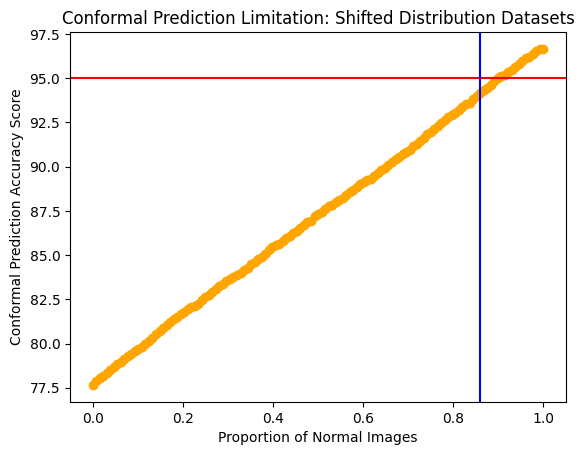

In [ ]:
dem = np.full(129, 128)
num = np.linspace(0, 128, num = 129)
proportion_normal = np.divide(num,dem)



import matplotlib.pyplot as plt
print(len(scores))
print(len(proportion_normal))

x = proportion_normal
y = scores
fig = plt.plot(figsize = (10, 5))
plt.scatter(x, y, color = 'orange')
# specifying horizontal line type 
plt.axhline(y = 95, color = 'r', linestyle = '-') 
plt.axvline(x = split_amount/batch_size, color = 'b', linestyle = '-' )

plt.xlabel("Proportion of Normal Images")
plt.ylabel("Conformal Prediction Accuracy Score")
plt.title("Conformal Prediction Limitation: Shifted Distribution Datasets")
plt.show()


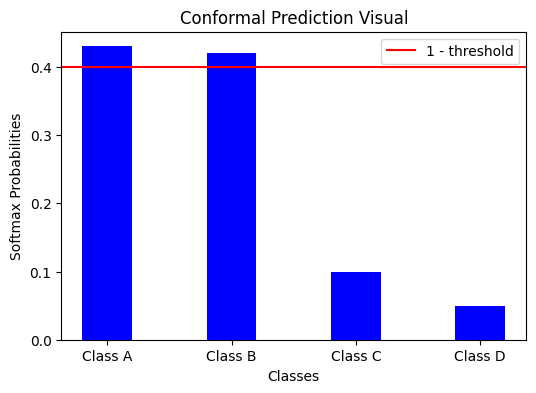

In [ ]:
#fake data
data = {'Class A': 0.43,
        'Class B': 0.42,
        'Class C': 0.10,
        'Class D': 0.05,
}

threshold = 0.6

classes = list(data.keys())
softmax = list(data.values())

fig, axs = plt.subplots(figsize=(6, 4))
axs.bar(classes, softmax, color = 'blue', width = 0.4)
axs.axhline(y = 1 - threshold, color = 'r', linestyle = '-', label = '1 - threshold') 

plt.xlabel("Classes")
plt.ylabel("Softmax Probabilities")
plt.title("Conformal Prediction Visual")
plt.legend()
plt.show()


In [ ]:
'''''import cv2



rotate_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

observed_labels = []
with torch.no_grad():
    for images, labels in mnist_test_loader:
        observed_labels.extend(labels.cpu().numpy())


def rotate_image(image):
    image = image.numpy().squeeze()  # Convert to numpy array and remove batch dimension
    rows, cols = image.shape
    rotated_image = cv2.warpAffine(image, dsize=None, M=cv2.getRotationMatrix2D((cols / 2, rows / 2), -120, 1))
    return torch.tensor(rotated_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension back

rotated_images = []
rotated_labels = []

with torch.no_grad():
    for images, labels in mnist_test_loader:
        for i in range(len(images)):
            rotated_image = rotate_image(images[i])
            rotated_images.append(rotated_image)
            rotated_labels.append(labels[i])


rotated_images = torch.stack(rotated_images)
rotated_labels = torch.tensor(rotated_labels)

# Evaluate the model on the rotated test set
rotate_probs = []
rotate_preds = []

# Flatten images for model input
rotated_images = rotated_images.view(len(rotated_images), -1).to(device)


# Evaluate the model on the entire rotated test set at once
with torch.no_grad():
    outputs = model(rotated_images) #
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, rotate_preds = torch.max(outputs.data, 1)

rotate_preds = rotate_preds.cpu().numpy()
rotate_probs = probabilities.cpu().numpy()

conformal_predictions = conformal_prediction(rotate_probs, threshold)
print("flip evaluation:")
evaluate_and_print(observed_labels, conformal_predictions, rotate_preds, 10, 200)

'''''


'\'\'import cv2\n\n\n\nrotate_loader = torch.utils.data.DataLoader(dataset=mnist_test_dataset,\n                                          batch_size=batch_size,\n                                          shuffle=False)\n\nobserved_labels = []\nwith torch.no_grad():\n    for images, labels in mnist_test_loader:\n        observed_labels.extend(labels.cpu().numpy())\n\n\ndef rotate_image(image):\n    image = image.numpy().squeeze()  # Convert to numpy array and remove batch dimension\n    rows, cols = image.shape\n    rotated_image = cv2.warpAffine(image, dsize=None, M=cv2.getRotationMatrix2D((cols / 2, rows / 2), -120, 1))\n    return torch.tensor(rotated_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension back\n\nrotated_images = []\nrotated_labels = []\n\nwith torch.no_grad():\n    for images, labels in mnist_test_loader:\n        for i in range(len(images)):\n            rotated_image = rotate_image(images[i])\n            rotated_images.append(rotated_image)\n            